<a href="https://colab.research.google.com/github/davidfague/4540_NM_ML/blob/main/EEG_eyes_open__closed_alpha_waves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[What is EEG and time-frequency analysis?](https://youtu.be/FIqvTUOGFOE?si=5hFMbAp3RpghlKoM)



[How to make predictions based on EEG?](https://youtu.be/SKIaW5YvF6Y?si=R5AlNCTIsh3AjNkn)

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import scipy.signal as ss

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Welcome
This notebook will walk you through how to analyse brain wave data. This data was collected in the Neural Engineering Laboratory at the University of Missouri - Columbia.

In [40]:
from google.colab import drive

drive.mount('/content/drive')

# Access the file from Google Drive
df = pd.read_csv('/content/drive/My Drive/OpenBCI-RAW-2020-03-10_08-53-44.txt',skiprows=6,header=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
#df = pd.read_csv('OpenBCI-RAW-2020-03-10_08-53-44.txt',skiprows=6,header=None)

In [42]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0,-76.20,1.38,-34.35,-51.09,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
1,1,-36.12,29.01,76.34,48.51,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
2,2,-43.59,31.42,58.11,30.55,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
3,3,-77.29,2.68,-19.45,-49.45,0.912,0.112,-0.464,08:54:30.274,1.583848e+12
4,4,-57.05,17.48,52.08,23.03,0.912,0.112,-0.464,08:54:30.274,1.583848e+12


In [43]:
df.columns=['index','channel1','channel2','channel3','channel4','acc1','acc2','acc3','time_std','timestamp']
df.drop(['index'],axis=1,inplace=True)

In [44]:
df.head()

,channel1,channel2,channel3,channel4,acc1,acc2,acc3,time_std,timestamp
0,-76.20,1.38,-34.35,-51.09,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
1,-36.12,29.01,76.34,48.51,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
2,-43.59,31.42,58.11,30.55,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
3,-77.29,2.68,-19.45,-49.45,0.912,0.112,-0.464,08:54:30.274,1.583848e+12
4,-57.05,17.48,52.08,23.03,0.912,0.112,-0.464,08:54:30.274,1.583848e+12


# Explanation of the data
As you can see the dataframe consists of 8 columns. Each row is a sample. The data was sampled at 200 Hz. That means 200 samples per second. There are four channels on the EEG device, two of these were place on the frontal lobe (forehead) and two on the temporal lobe (sides of the head). The acc1-3 channels are the accelerometer. If the subject moves, these channels will detect that. The time is represented by the final two columns.

Below, we will plot the entire time course of one channel.

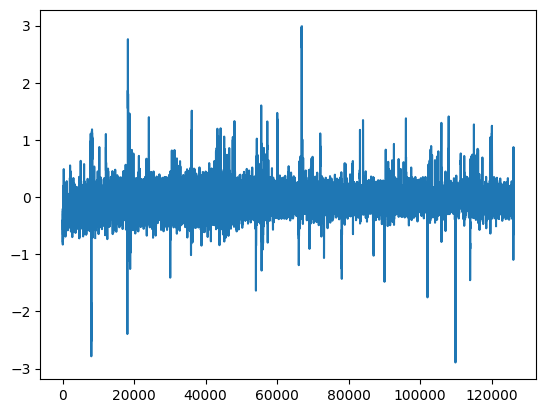

In [75]:
plt.figure()
plt.plot(df['channel2'])

Question 1. What should the axes be labeled on the plot above?

# Remove drift
The mean of the data changes over time. This is called drift. We can remove this trend in the data using scipy's detrend function.

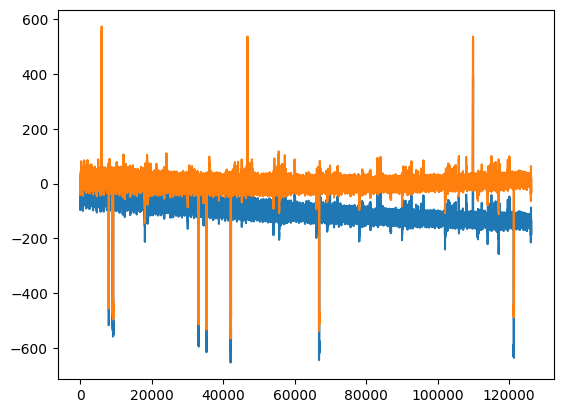

In [46]:
plt.plot(df['channel1'])
plt.plot(ss.detrend(df['channel1']))

In [47]:
df['channel1'] = ss.detrend(df['channel1'])
df['channel2'] = ss.detrend(df['channel2'])
df['channel3'] = ss.detrend(df['channel3'])
df['channel4'] = ss.detrend(df['channel4'])

Question 2. Where does drift come from?

# Artifact removal
Whenever the subject moved or blinked, there is a large deviation in the potential of all channels. We need to remove these.

In [48]:
zchan1 = (df['channel1']-np.mean(df['channel1']))/np.std(df['channel1'])
zchan2 = (df['channel2']-np.mean(df['channel2']))/np.std(df['channel2'])
zchan3 = (df['channel3']-np.mean(df['channel3']))/np.std(df['channel3'])
zchan4 = (df['channel4']-np.mean(df['channel4']))/np.std(df['channel4'])

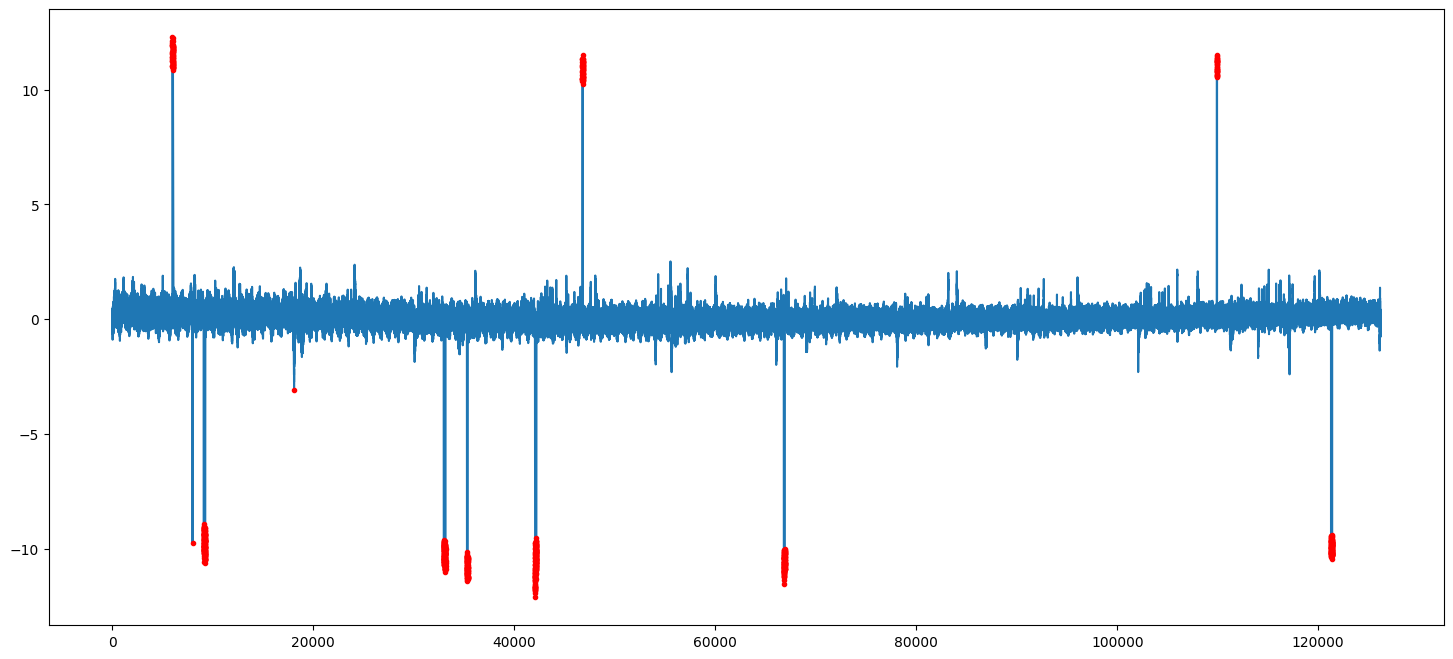

In [49]:
plt.figure(figsize=(18,8))
plt.plot(zchan1)
plt.plot(zchan1[np.abs(zchan1)>3],'r.')

Most of these are artifacts.

Question 3. What is one source of artifacts?

# Make y labels
The subject was in two states during the experiment; their eyes were either open or closed. Below, we define the times at which the eyes were open or closed.

In [50]:
df['seconds_from_start']=(df['timestamp']-df['timestamp'].iloc[0])/1000

In [51]:
y_labels = np.zeros((df['time_std'].shape[0],1))

In [52]:
y_labels[(60<df.seconds_from_start)&(df.seconds_from_start<90)] = 1
y_labels[(120<df.seconds_from_start)&(df.seconds_from_start<150)] = 1
y_labels[(180<df.seconds_from_start)&(df.seconds_from_start<210)] = 1
y_labels[(240<df.seconds_from_start)&(df.seconds_from_start<270)] = 1
y_labels[(300<df.seconds_from_start)&(df.seconds_from_start<330)] = 1
y_labels[(360<df.seconds_from_start)&(df.seconds_from_start<390)] = 1
y_labels[(420<df.seconds_from_start)&(df.seconds_from_start<450)] = 1
y_labels[(480<df.seconds_from_start)&(df.seconds_from_start<510)] = 1
y_labels[(540<df.seconds_from_start)&(df.seconds_from_start<570)] = 1
y_labels[(600<df.seconds_from_start)&(df.seconds_from_start<630)] = 1

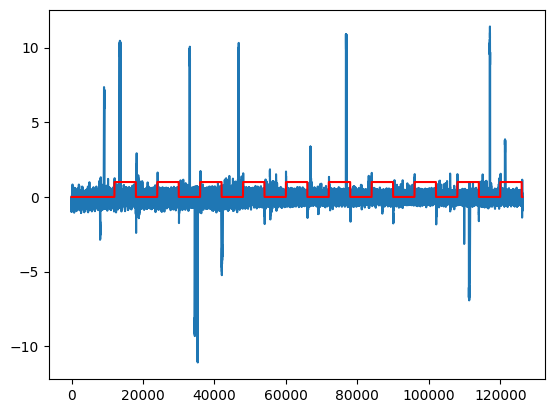

In [53]:
plt.plot(zchan2)
plt.plot(y_labels,'r')

In the plot above, the trace of a single channel is shown in blue and whether or not the eyes were closed is shown in red. y_labels == 1 means eyes closed and y_labels == 0 means eyes open.

Remove 60 Hz noise and artifacts. Any time a signal is recorded inside of a building, there will be a prominent 60 Hz noise from the power lines. We will remove this using a notch filter.

Question 4. What are the 'groundtruth' classifications for this data? Where do they come from?

In [54]:
b, a = ss.iirnotch(60.0, 200.0, 200.)

zchan1 = ss.filtfilt(b,a,zchan1)
zchan2 = ss.filtfilt(b,a,zchan2)
zchan3 = ss.filtfilt(b,a,zchan3)
zchan4 = ss.filtfilt(b,a,zchan4)

zchan1[np.abs(zchan1)>3] = np.nan
zchan2[np.abs(zchan2)>3] = np.nan
zchan3[np.abs(zchan3)>3] = np.nan
zchan4[np.abs(zchan4)>3] = np.nan
y_labels[(np.abs(zchan1)>3) | (np.abs(zchan2)>3) | (np.abs(zchan3)>3) | (np.abs(zchan4)>3)] = np.nan

In [55]:
df['channel1'] = zchan1
df['channel2'] = zchan2
df['channel3'] = zchan3
df['channel4'] = zchan4
df['y_labels'] = y_labels

The below graph shows the difference between eyes closed and eyes open in the frequency domain. It is well known that the eyes closed condition generates alpha waves at 8-12 Hz, which we also see in this recording. There may still be some 60 Hz noise that our notch filter failed to remove.

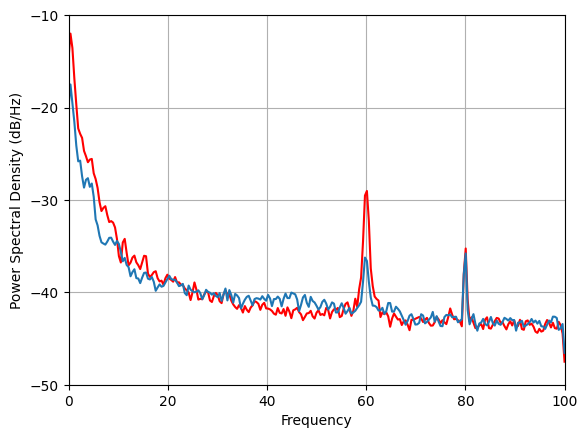

In [77]:
X = df['channel2'].iloc[y_labels[:,0]==0]
plt.psd(X[~np.isnan(X)],512,Fs=200,color='r')
X = df['channel2'].iloc[y_labels[:,0]==1]
plt.psd(X[~np.isnan(X)],512,Fs=200)
plt.xlim(0,100)
#plt.show()
plt.show()

Question 5. What 'noise' causes the peak at 60 Hz frequency? What about 80 Hz? Will there be peaks at multiples of these frequencies i.e. 120 Hz? What is the name of the structure that neuroscience researchers perform electrophysiology inside to eliminate such noise?

In [57]:
from scipy.integrate import simps
import scipy.stats as sst
from matplotlib.mlab import psd

def bandpower(trace,band):
    [a1,f1]=psd(trace[~np.isnan(trace)],512,Fs=200)
    total_power1 = simps(a1, dx=0.1)
    ap1 = simps(a1[(f1>band[0]) & (f1<band[1])], dx=0.1)
    return ap1/total_power1

input_mat = np.zeros((600,21))
c=0
for i in np.arange(0,120000,200):

    X1=df['channel1'];X2=df['channel2'];X3=df['channel3'];X4 = df['channel4']
    Y = df['y_labels']

    X1=X1[i:i+200];X2=X2[i:i+200];X3=X3[i:i+200];X4=X4[i:i+200]
    Y=Y[i:i+200]

    input_mat[c,0] = bandpower(X1,[8,12]);input_mat[c,1] = bandpower(X2,[8,12]);
    input_mat[c,2] = bandpower(X3,[8,12]);input_mat[c,3] = bandpower(X4,[8,12]);

    input_mat[c,4] = bandpower(X1,[3,8]);input_mat[c,5] = bandpower(X2,[3,8]);
    input_mat[c,6] = bandpower(X3,[3,8]);input_mat[c,7] = bandpower(X4,[3,8]);

    input_mat[c,8] = bandpower(X1,[12,38]);input_mat[c,9] = bandpower(X2,[12,38]);
    input_mat[c,10] = bandpower(X3,[12,38]);input_mat[c,11] = bandpower(X4,[12,38]);

    input_mat[c,12] = bandpower(X1,[38,100]);input_mat[c,13] = bandpower(X2,[38,100]);
    input_mat[c,14] = bandpower(X3,[38,100]);input_mat[c,15] = bandpower(X4,[38,100]);

    input_mat[c,16] = bandpower(X1,[0.5,3]);input_mat[c,17] = bandpower(X2,[0.5,3]);
    input_mat[c,18] = bandpower(X3,[0.5,3]);input_mat[c,19] = bandpower(X4,[0.5,3]);

    [u,n] = np.unique(Y,return_counts=True)
    if n.shape[0]==1:
        input_mat[c,-1] = u[0].astype(int)
    else:
        input_mat[c,-1] = np.nan

    c+=1

feat_eng_df = pd.DataFrame(input_mat, columns = ['alpha_power_1','alpha_power_2','alpha_power_3','alpha_power_4',
                                                 'theta_power_1','theta_power_2','theta_power_3','theta_power_4',
                                                 'beta_power_1','beta_power_2','beta_power_3','beta_power_4',
                                                 'gamma_power_1','gamma_power_2','gamma_power_3','gamma_power_4',
                                                 'delta_power_1','delta_power_2','delta_power_3','delta_power_4',
                                                 'eyes_closed'])

<Axes: xlabel='eyes_closed', ylabel='alpha_power_3'>

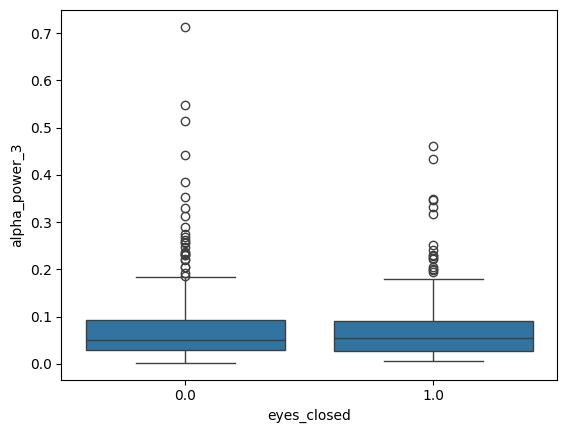

In [58]:
import seaborn as sns
sns.boxplot(x='eyes_closed',y='alpha_power_3',data=feat_eng_df)

# Feature Engineering Model

In [59]:
from sklearn.preprocessing import scale

train_df = feat_eng_df.iloc[0:420,:]
test_df = feat_eng_df.iloc[420:,:]

train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

X_train = X_train[~np.isnan(y_train)]
y_train = y_train[~np.isnan(y_train)]
X_test = X_test[~np.isnan(y_test)]
y_test = y_test[~np.isnan(y_test)]


X_train = scale(X_train)
X_test = scale(X_test)

In [60]:
X_train.shape, X_test.shape

((408, 20), (174, 20))

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

#initialize models
lr = LogisticRegression(random_state=231)
rf = RandomForestClassifier(random_state=2124)
mlp = MLPClassifier(hidden_layer_sizes=(5,),early_stopping=True,max_iter=1000,random_state=12)

# Train models on the training data and their measured classifications
lr.fit(X_train,y_train.values)
rf.fit(X_train,y_train.values)
mlp.fit(X_train,y_train.values)

yhatlr = lr.predict(X_test) # use models to make predictions on the testing data
yhatrf = rf.predict(X_test)
yhatmlp = mlp.predict(X_test)

# compare model-predicted classifications with measured classifications
print(confusion_matrix(y_test,yhatlr)) # Linear Regression confusion matrix
print(confusion_matrix(y_test,yhatrf)) # Random Forest confusion matrix
print(confusion_matrix(y_test,yhatmlp)) # Multi-Layer Perceptron confusion matrix

[[72 15]
 [31 56]]
[[61 26]
 [32 55]]
[[55 32]
 [64 23]]


Question 6. Briefly describe the algorithms: Logistic Regression, Random Forest Classifier, and Multi-Layer Perceptron Classifier.

Question 7. What is a confusion Matrix? What information do the above numbers convey? How do you estimate accuracy from confusion matrix? Compute the accuracy of the 3 models and compare them.

# Model raw data

Below we transform the data into a frame suitable for supervised learning. A window size of 50 represents 0.25 seconds.

In [62]:
df_train = df[df.seconds_from_start<=420]
df_test = df[df.seconds_from_start>420]

In [63]:
df_train.head()

,channel1,channel2,channel3,channel4,acc1,acc2,acc3,time_std,timestamp,seconds_from_start,y_labels
0,-0.219697,-0.774254,-0.099779,-0.503364,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
1,0.253886,-0.442505,1.015076,0.527823,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
2,0.111783,-0.453969,0.839341,0.320779,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
3,-0.232359,-0.767459,0.220389,-0.413223,0.912,0.112,-0.464,08:54:30.274,1.583848e+12,0.011,0.0
4,-0.051354,-0.574461,0.868939,0.340731,0.912,0.112,-0.464,08:54:30.274,1.583848e+12,0.011,0.0


In [64]:
from tqdm import tqdm_notebook

window_size = 50
stride=20

df_class_train = np.zeros((int(df_train.shape[0]/stride),window_size+1,4))
c=0
for i in tqdm_notebook(np.arange(0,df_train.shape[0]-window_size,stride)):
    df_class_train[c,0:window_size,0] = df_train['channel1'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,1] = df_train['channel2'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,2] = df_train['channel3'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,3] = df_train['channel4'].iloc[i:i+window_size]

    ylabs = df_train['y_labels'].iloc[i:i+window_size]
    ones=ylabs[ylabs==1]
    zeros=ylabs[ylabs==0]

    if ones.shape[0]>zeros.shape[0]:
        df_class_train[c,-1,:] = 1
    else:
        df_class_train[c,-1,:] = 0
    c+=1

df_class_test = np.zeros((int(df_test.shape[0]/stride),window_size+1,4))
c=0
for i in tqdm_notebook(np.arange(0,df_test.shape[0]-window_size,stride)):
    df_class_test[c,0:window_size,0] = df_test['channel1'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,1] = df_test['channel2'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,2] = df_test['channel3'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,3] = df_test['channel4'].iloc[i:i+window_size]

    ylabs = df_test['y_labels'].iloc[i:i+window_size]
    ones=ylabs[ylabs==1]
    zeros=ylabs[ylabs==0]

    if ones.shape[0]>zeros.shape[0]:
        df_class_test[c,-1,:] = 1
    else:
        df_class_test[c,-1,:] = 0
    c+=1


<ipython-input-64-fe3449376fee>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(np.arange(0,df_train.shape[0]-window_size,stride)):


  0%|          | 0/4197 [00:00<?, ?it/s]

<ipython-input-64-fe3449376fee>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(np.arange(0,df_test.shape[0]-window_size,stride)):


  0%|          | 0/2109 [00:00<?, ?it/s]

Remove NaN rows

In [65]:
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,0]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,1]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,2]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,3]).any(axis=1),:,:]

df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,0]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,1]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,2]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,3]).any(axis=1),:,:]

In [66]:
df_class_train.shape,df_class_test.shape

((4061, 51, 4), (2064, 51, 4))

# Feature engineering

Here I manually engineer some features and try some basic models on that transformed data.

In [67]:
df_class_train.shape

(4061, 51, 4)

In [68]:
import scipy
################ TRAIN #######################
X=np.mean(df_class_train[:,:-1,:],axis=1)
Y=np.var(df_class_train[:,:-1,:],axis=1)
Z=scipy.stats.skew(df_class_train[:,:-1,:],axis=1)
W=scipy.stats.kurtosis(df_class_train[:,:-1,:],axis=1)

ds = np.concatenate((X,Y,Z,W,df_class_train[:,-1,0:1]),axis=1)
np.random.shuffle(ds)

df_feats_train = pd.DataFrame(ds,columns=['meanch1','meanch2','meanch3','meanch4',\
                                    'varch1','varch2','varch3','varch4',\
                                    'skewch1','skewch2','skewch3','skewch4',\
                                    'kurtch1','kurtch2','kurtch3','kurtch4','output'])
################ TEST #######################
X=np.mean(df_class_test[:,:-1,:],axis=1)
Y=np.var(df_class_test[:,:-1,:],axis=1)
Z=scipy.stats.skew(df_class_test[:,:-1,:],axis=1)
W=scipy.stats.kurtosis(df_class_test[:,:-1,:],axis=1)

ds = np.concatenate((X,Y,Z,W,df_class_test[:,-1,0:1]),axis=1)
np.random.shuffle(ds)

df_feats_test = pd.DataFrame(ds,columns=['meanch1','meanch2','meanch3','meanch4',\
                                    'varch1','varch2','varch3','varch4',\
                                    'skewch1','skewch2','skewch3','skewch4',\
                                    'kurtch1','kurtch2','kurtch3','kurtch4','output'])

Question 8. What are the features that were manually engineered? Describe them briefly. (hint: X,Y, Z, W)? In your own words, describe feature engineering.

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

rf = RandomForestClassifier()
lr = LogisticRegression()
pca = PCA()

  # get training Data
X_train = df_feats_train.loc[:, df_feats_train.columns != 'output']
y_train = df_feats_train.loc[:, df_feats_train.columns == 'output']
# Remove NaNs while maintaining consistent number of samples of both x and y
df_merged = pd.merge(X_train, y_train, left_index=True, right_index=True) # Merge X_train and y_train into a single DataFrame
df_merged.dropna(inplace=True) # Delete any rows that contain NaNs
# Separate X_train and y_train again
X_train = df_merged.loc[:, df_merged.columns != 'output']
y_train = df_merged.loc[:, df_merged.columns == 'output']


  # get testing data
X_test = df_feats_test.loc[:, df_feats_test.columns != 'output']
y_test = df_feats_test.loc[:, df_feats_test.columns == 'output']
# Remove NaNs while maintaining consistent number of samples of both x and y
df_merged = pd.merge(X_test, y_test, left_index=True, right_index=True) # Merge X_train and y_train into a single DataFrame
df_merged.dropna(inplace=True) # Delete any rows that contain NaNs
# Separate X_train and y_train again
X_test = df_merged.loc[:, df_merged.columns != 'output']
y_test = df_merged.loc[:, df_merged.columns == 'output']

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=212) # older method

rf.fit(X_train,y_train)
lr.fit(X_train,y_train)
pca.fit(X_train,y_train)

yhat_rf = rf.predict(X_test)
yhat_lr = lr.predict(X_test)


print(confusion_matrix(y_test,yhat_rf))
print(confusion_matrix(y_test,yhat_lr))

<ipython-input-69-da260567845c>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[661 235]
 [601 566]]
[[626 270]
 [558 609]]


Question 10. What is Principal Component Analysis (PCA)? What does it tell us about our chosen features?

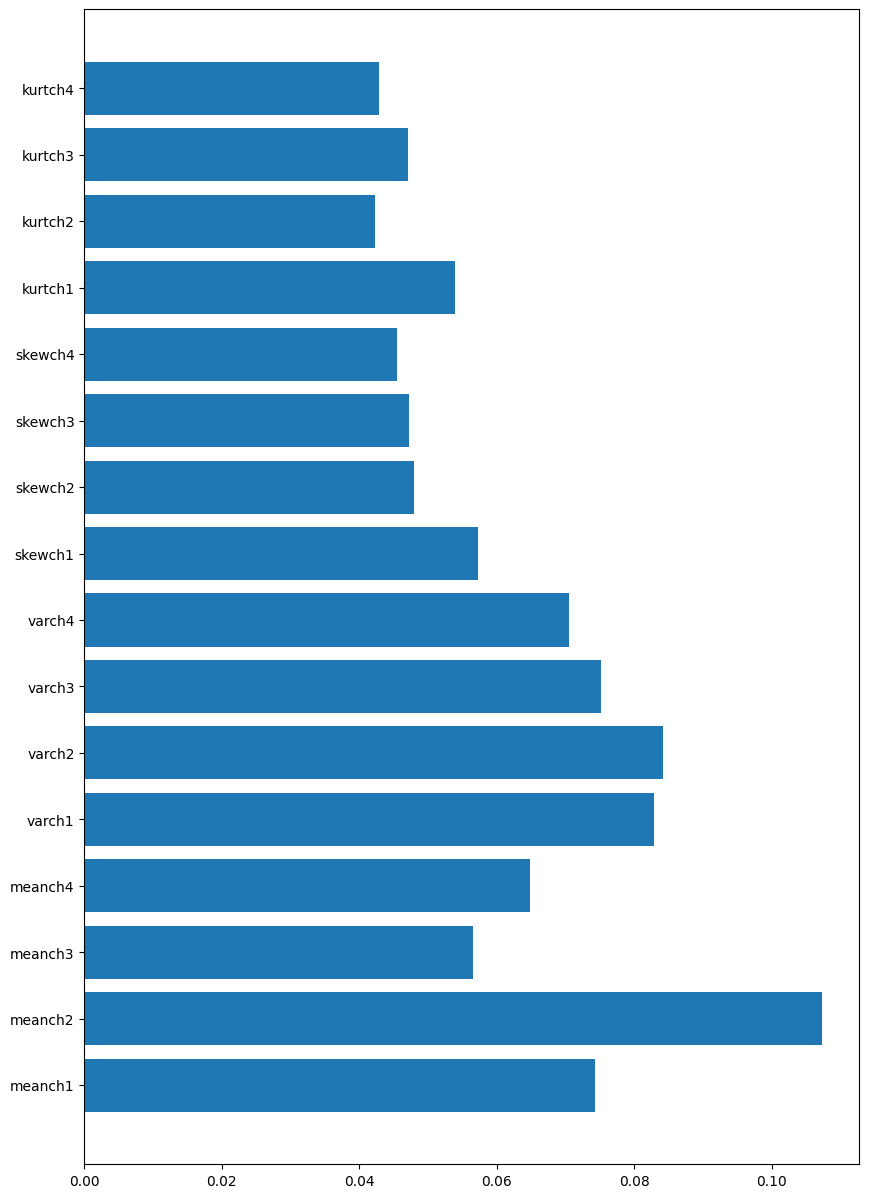

In [70]:
plt.figure(figsize=(10,15))
y_pos = np.arange(len(X_train.columns))
plt.barh(y_pos, rf.feature_importances_)

# Create names on the y-axis
plt.yticks(y_pos, X_train.columns)
plt.show()

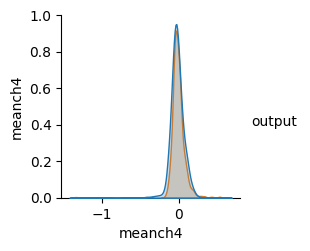

In [71]:
import seaborn as sns
sns.pairplot(pd.concat((X_train[['meanch4']],y_train),axis=1),hue='output')

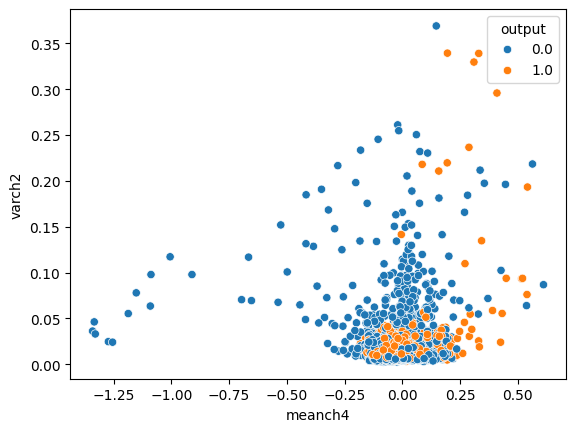

In [72]:
sns.scatterplot(x='meanch4',y='varch2',hue='output',data=pd.concat((X_train,y_train),axis=1))
plt.show()

Question 11. Based on the plot above, could the variance of channel2 be a good predictor? Why or why not? Could the mean of ch 4 be a good predictor? Why or why not?

In [73]:
def focal_loss(gamma=4, alpha=0.15):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

# load the dataset, returns train and test X and y elements
def load_dataset(dftrain,dftest):
    trainX = dftrain[:,:-1,:]
    trainy = dftrain[:,-1,0:1]

    testX = dftest[:,:-1,:]
    testy = dftest[:,-1,0:1]

    shuff_idx = np.random.choice(np.arange(0,trainX.shape[0]),trainX.shape[0],replace=False)
    trainX = trainX[shuff_idx,:,:]
    trainy = trainy[shuff_idx]

    shuff_idx = np.random.choice(np.arange(0,testX.shape[0]),testX.shape[0],replace=False)
    testX = testX[shuff_idx,:,:]
    testy = testy[shuff_idx]

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 200, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    er = EarlyStopping(patience=10, min_delta=1e-4, monitor='val_accuracy')
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
              validation_split=0.15, callbacks=[er])
    return model

# fit and evaluate a model
def evaluate_model2d(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    input_layer = Input(shape=(trainX.shape[1], trainX.shape[2], trainX.shape[3]))

    # handle image dimensions ordering
    if tf.keras.backend.image_data_format() == 'channels_first':
        latent = Permute((3, 1, 2))(input_layer)
    else:
        latent = input_layer

    # define the network architecture
    latent = Conv2D(filters=32, kernel_size=(3, 3),
                        activation='relu')(latent)
    latent = Conv2D(filters=64, kernel_size=(3, 3),
                        activation='relu')(latent)
    latent = Dropout(0.5)(latent)
    latent = MaxPooling2D(pool_size=(2, 2))(latent)
    latent = Flatten()(latent)
    latent = Dense(units=100, activation='relu')(latent)
    output_layer = Dense(units=trainy.shape[1], activation='softmax')(latent)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    er = EarlyStopping(patience=10, min_delta=1e-4, monitor='val_accuracy')
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
              validation_split=0.15, callbacks=[er])
    return model

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment():
    # load data

    trainX, trainy, testX, testy = load_dataset(df_class_train,df_class_test)
    # repeat experiment
    scores = list()

    model = evaluate_model(trainX, trainy, testX, testy)

    ypred = model.predict(testX)
    class_preds = np.argmax(ypred, axis=-1)
    testy = np.argmax(testy,axis=-1)

    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(testy,class_preds))
    return model

In [37]:
model = run_experiment()

(4061, 50, 4) (4061, 2) (2064, 50, 4) (2064, 2)
Epoch 1/200
108/108 [==============================] - 3s 14ms/step - loss: 0.6312 - accuracy: 0.6103 - val_loss: 0.5943 - val_accuracy: 0.6557
Epoch 2/200
108/108 [==============================] - 1s 13ms/step - loss: 0.5922 - accuracy: 0.6523 - val_loss: 0.5789 - val_accuracy: 0.6803
Epoch 3/200
108/108 [==============================] - 1s 13ms/step - loss: 0.5633 - accuracy: 0.6859 - val_loss: 0.5403 - val_accuracy: 0.7082
Epoch 4/200
108/108 [==============================] - 1s 11ms/step - loss: 0.5322 - accuracy: 0.7198 - val_loss: 0.5268 - val_accuracy: 0.7131
Epoch 5/200
108/108 [==============================] - 1s 11ms/step - loss: 0.5012 - accuracy: 0.7554 - val_loss: 0.4847 - val_accuracy: 0.7607
Epoch 6/200
108/108 [==============================] - 1s 12ms/step - loss: 0.4592 - accuracy: 0.7725 - val_loss: 0.4980 - val_accuracy: 0.7574
Epoch 7/200
108/108 [==============================] - 2s 18ms/step - loss: 0.4309 - acc

Question 12. Compute the 'accuracy' of this model (true positives + true negatives)/ (total). Is this model (CNN) more accurate than the previous models (LogReg, RF, MLP)? Were the manually engineered features better?

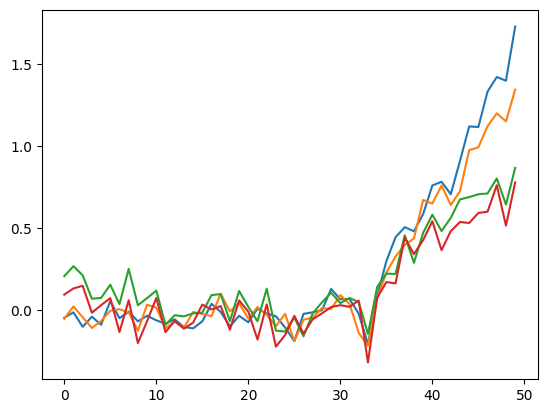

In [38]:
%matplotlib inline
plt.plot(df_class_test[0,:-1,0])
plt.plot(df_class_test[0,:-1,1])
plt.plot(df_class_test[0,:-1,2])
plt.plot(df_class_test[0,:-1,3])

Question 13. Read & briefly summarize in your own words significant points of information from the following MATLAB EEGLab tutorials: https://eeglab.org/tutorials/

Sections:
5. Preprocess data - a. Filtering
6. Reject artifacts - all sections a-d.
8. Plot data - all sections a-e.

***What did you learn from the EEGLab tutorials about EEG, Filtering, and Artifacts that you did not yet know?***

(Suggested/Optional) Download & use the MATLAB EEGLab on the dataset used in this notebook to try EEGLab yourself and get a better understanding of the tutorials.